## Cape Cod - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#! python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

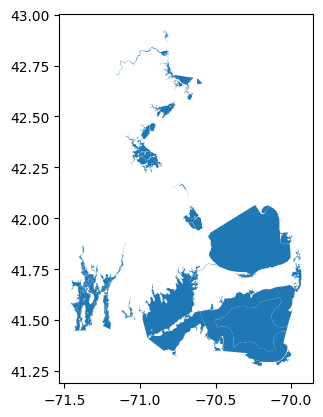

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(10615, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(10615, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits'}

<Axes: >

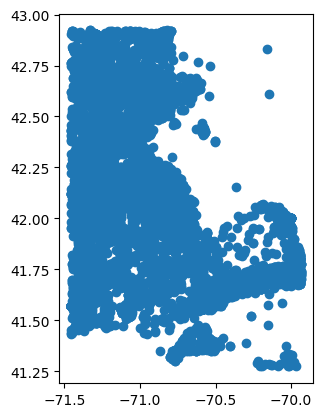

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

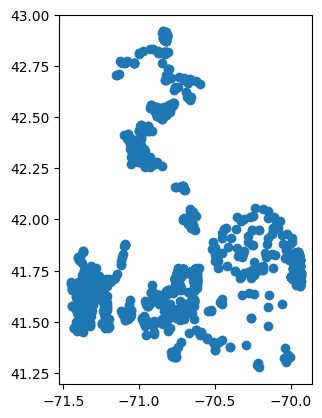

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1530

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,130809111433.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-m41:20131017:FM:B,2013-10-17,NaN,NaN,WTGHA-M41,STORET-1041401688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-m43:20130606:FM:B,2013-06-06,NaN,NaN,WTGHA-M43,STORET-1041402048,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX30_21_7/22/2013_SFW_0.01,2013-07-22,11:01:00,EDT,11NPSWRD_WQX-CACO_HX30_21,STORET-986369728,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457005,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,EST,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457006,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457007,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
457008,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

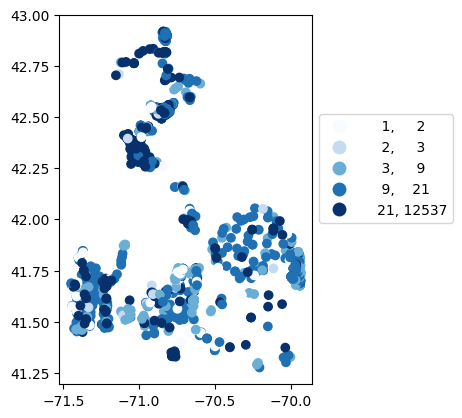

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    4865.000000
mean      -12.374142
std       405.355648
min     -9999.000000
25%         1.600000
50%         3.500000
75%         6.000000
max        17.000000
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2419.7597455697523): 16


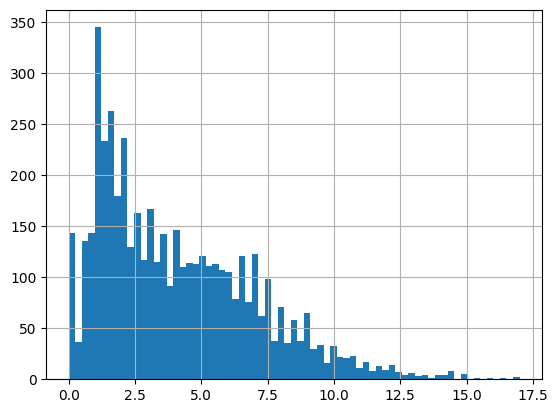

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, "Depth, Secchi disk depth", errors="ignore", intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
21,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
161,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
369,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
695,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
718,11113300-GRTKINSD,4.75,m,NaN,m,4.75 meter
...,...,...,...,...,...,...
456320,11NPSWRD_WQX-CACO_DUCK_W,16.5,m,NaN,m,16.5 meter
456321,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
456322,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
456323,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
12541,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
35945,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
38833,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
40824,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
43077,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
368132,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368212,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368568,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
369321,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
12541,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
35911,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
35945,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
36092,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
37309,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
368132,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368212,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
368568,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
369321,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
691,WWMD_VA-SH1,2,1.500000
692,WWMD_VA-SH2,2,1.800000
693,WWMD_VA-SR6A,1,0.500000
694,WWMD_VA-WF2,1,0.600000


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

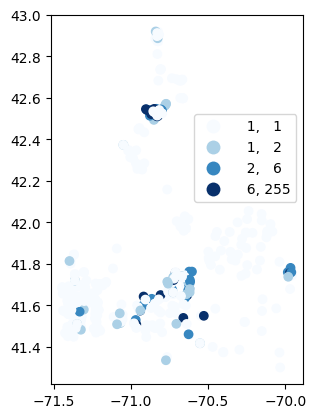

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

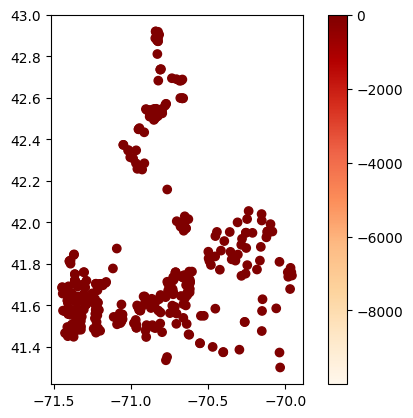

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    125598.00000
mean         16.02333
std           7.32987
min          -6.00000
25%          11.00000
50%          16.80000
75%          21.66000
max         910.00000
dtype: float64
Unusable results: 213
Usable results with inferred units: 217
Results outside threshold (0.0 to 60.00254815453248): 177


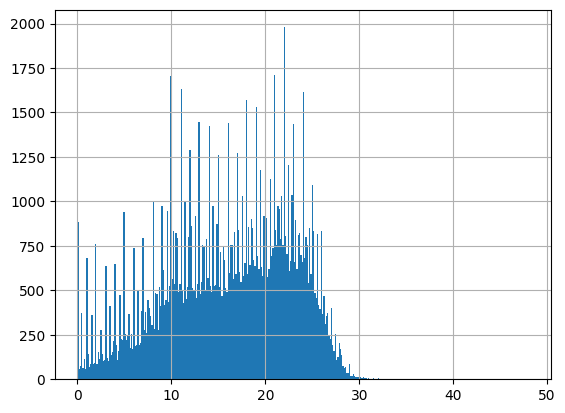

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
0,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
2,WTGHA-M43,17.39,deg C,NaN,17.39 degree_Celsius,degC
10,CRWA-635S,5.5,deg C,NaN,5.5 degree_Celsius,degC
19,CRWA-4LONG,28.2,deg C,NaN,28.2 degree_Celsius,degC
28,BRC-C-02-03-040,15,deg C,NaN,15.0 degree_Celsius,degC
...,...,...,...,...,...,...
456992,USGS-413831070304703,11.3,deg C,NaN,11.3 degree_Celsius,degC
456994,USGS-01100627,7.0,deg C,NaN,7.0 degree_Celsius,degC
456998,USGS-01096548,2.9,deg C,NaN,2.9 degree_Celsius,degC
457002,USGS-01098530,1.5,deg C,NaN,1.5 degree_Celsius,degC


In [34]:
# Examine deg F
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'] == 'deg F']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
19570,NALMS-F865245,81,deg F,NaN,27.222222222222285 degree_Celsius,degF
28249,11113300-HOODERD,59.2,deg F,NaN,15.111111111111143 degree_Celsius,degF
28658,11113300-HOODERD,59.1,deg F,NaN,15.0555555555556 degree_Celsius,degF
28988,11113300-HOODERD,59.9,deg F,NaN,15.500000000000057 degree_Celsius,degF
29552,11113300-HOODERD,56,deg F,NaN,13.333333333333371 degree_Celsius,degF
...,...,...,...,...,...,...
452836,11NPSWRD_WQX-SAIR_MEQ76_NC6,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF
452842,11NPSWRD_WQX-SAMA_MEQ76_NC18,71.0,deg F,NaN,21.666666666666686 degree_Celsius,degF
452845,11NPSWRD_WQX-SAMA_MEQ76_NC13,72.0,deg F,NaN,22.222222222222285 degree_Celsius,degF
452860,11NPSWRD_WQX-SAIR_MEQ76_NC3,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
120710,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
120711,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
120712,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
120713,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
120714,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
122052,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
122053,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
122055,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
170943,AQUINNAH-MEN PND HC,0.0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
320,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
3525,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
4105,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
5108,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
5462,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
285707,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
301067,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
302315,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
306797,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
5948,WWMD_VA-WWE1149PI,1,18.800000
5949,WWMD_VA-WWE1150PI,1,21.300000
5950,WWMD_VA-WWE1151PI,2,20.700000
5951,WWMD_VA-WWE1152PI,1,20.000000


<Axes: >

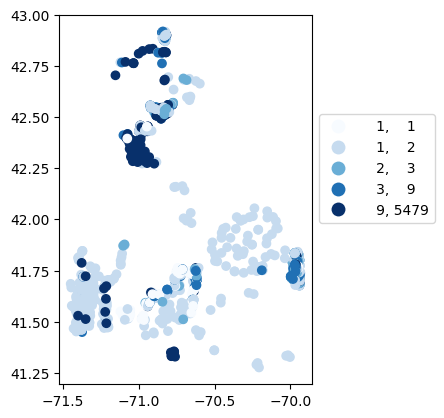

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

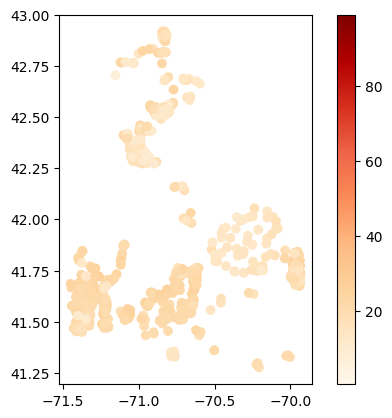

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
5,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
8,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
9,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
12,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
13,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
453490,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
453493,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
453494,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
453500,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
5,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
8,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
9,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
12,WTGHA-M46,24.7,mg/L,NaN,24.7 milligram / liter
13,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
...,...,...,...,...,...
453490,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
453493,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
453494,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
453500,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2343,WWMD_VA-SR5,1,10.810000
2344,WWMD_VA-WF2,2,6.800000
2345,WWMD_VA-WI1,1,9.510000
2346,WWMD_VA-WR2X,2,6.000000


<Axes: >

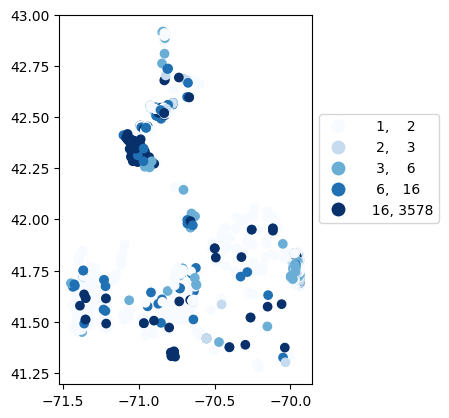

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

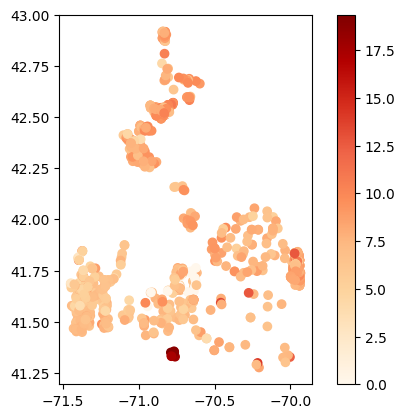

In [46]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'mV' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    100655.000000
mean          6.593598
std           2.583925
min          -3.124705
25%           5.800000
50%           6.700000
75%           7.500000
max         715.000000
dtype: float64
Unusable results: 2210
Usable results with inferred units: 215
Results outside threshold (0.0 to 22.097148230328724): 12


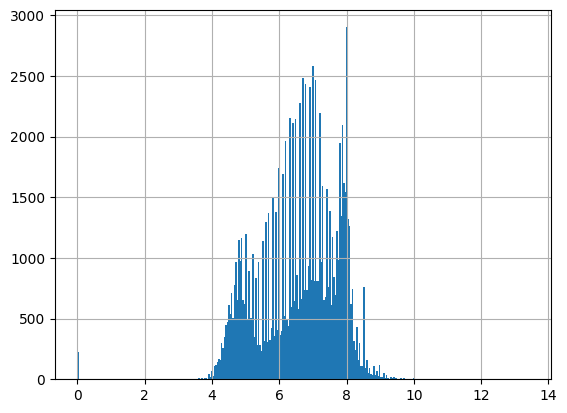

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, "pH", errors="ignore", report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
34,7.78,None,NaN,7.78 dimensionless
53,8.16,None,NaN,8.16 dimensionless
62,8.05,None,NaN,8.05 dimensionless
64,7.9,None,NaN,7.9 dimensionless
70,7.69,None,NaN,7.69 dimensionless
...,...,...,...,...
456993,5.8,std units,NaN,5.8 dimensionless
456995,7.3,std units,NaN,7.3 dimensionless
456999,7.4,std units,NaN,7.4 dimensionless
457003,7.5,std units,NaN,7.5 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/basis.py:154: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn(f"Mismatched {flag}", UserWarning)


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'deg C' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    36885.000000
mean        20.630282
std         25.215980
min          0.000000
25%          0.900000
50%         29.700000
75%         31.380000
max       4003.482834
dtype: float64
Unusable results: 218
Usable results with inferred units: 1
Results outside threshold (0.0 to 171.9261609723403): 2


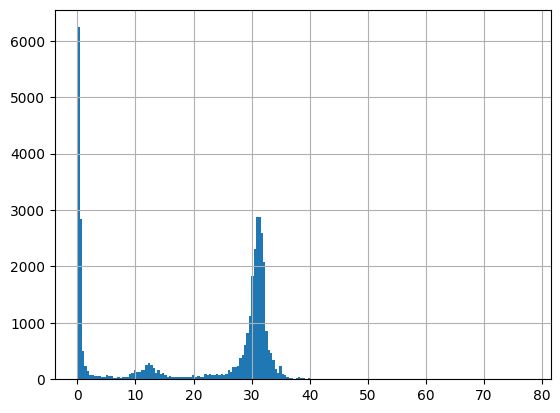

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
27,33.3,ppth,NaN,33.3 Practical_Salinity_Units
37,30.91,ppt,NaN,30.91 Practical_Salinity_Units
60,32.7,ppth,NaN,32.7 Practical_Salinity_Units
85,30.33,ppt,NaN,30.33 Practical_Salinity_Units
106,30.48,ppt,NaN,30.48 Practical_Salinity_Units
...,...,...,...,...
455801,9.9,PSU,NaN,9.9 Practical_Salinity_Units
456406,4.6,PSU,NaN,4.6 Practical_Salinity_Units
456506,21.0,PSU,NaN,21.0 Practical_Salinity_Units
456519,18.7,PSU,NaN,18.7 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


-Usable results-
count    2409.000000
mean        6.472302
std       106.930304
min         0.000800
25%         0.074000
50%         0.242000
75%         1.000000
max      2800.000000
dtype: float64
Unusable results: 243
Usable results with inferred units: 0
Results outside threshold (0.0 to 648.0541246058881): 6


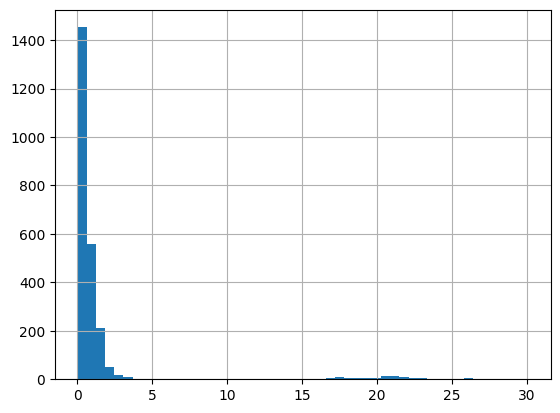

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
777,0.926976,mg/L,NaN,0.926976 milligram / liter
905,1.571196,mg/L,NaN,1.571196 milligram / liter
911,0.816144,mg/L,NaN,0.816144 milligram / liter
1227,0.848832,mg/L,NaN,0.848832 milligram / liter
1281,0.770448,mg/L,NaN,0.770448 milligram / liter
...,...,...,...,...
456826,0.119,mg/l,NaN,0.119 milligram / liter
456884,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
456927,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
456933,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     8662.000000
mean     23693.803883
std      17386.352366
min          0.000000
25%        621.000000
50%      27842.112921
75%      39970.000000
max      57700.000000
dtype: float64
Unusable results: 81
Usable results with inferred units: 0
Results outside threshold (0.0 to 128011.91807913117): 0


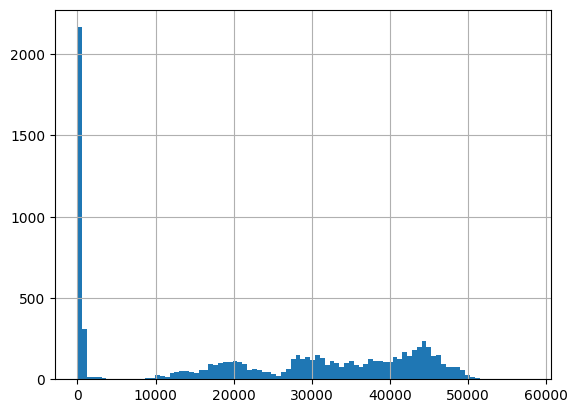

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True, errors='ignore')

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
22,349,uS/cm,NaN,349.0 microsiemens / centimeter
23,49.7,mS/cm,NaN,49700.0 microsiemens / centimeter
29,8,count,NaN,NaN
44,443,uS/cm,NaN,443.0 microsiemens / centimeter
52,67.11703531,uS/cm,NaN,67.11703531 microsiemens / centimeter
...,...,...,...,...
404648,20.579,mS/cm,NaN,20579.0 microsiemens / centimeter
404698,38.432,mS/cm,NaN,38432.0 microsiemens / centimeter
404705,37.791,mS/cm,NaN,37791.0 microsiemens / centimeter
404715,40.652,mS/cm,NaN,40652.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    4171.000000
mean        0.581802
std         3.280718
min        -0.002400
25%         0.001900
50%         0.005200
75%         0.019000
max        92.900000
dtype: float64
Unusable results: 202
Usable results with inferred units: 9
Results outside threshold (0.0 to 20.266111880769866): 29


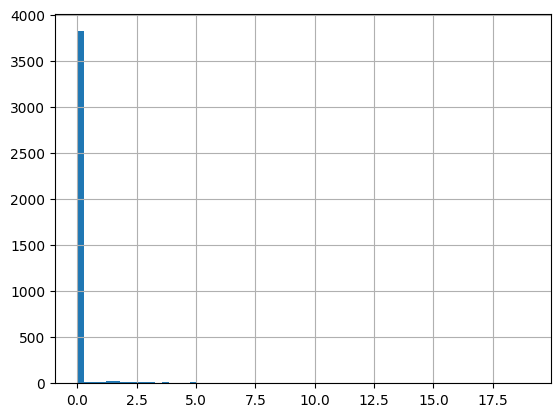

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
4,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
215,5.50,ug/L,NaN,0.0055 milligram / liter
406,9.48,ug/L,NaN,0.00948 milligram / liter
703,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
937,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
456710,0.5,ug/l,NaN,0.0005 milligram / liter
456717,2.5,ug/l,NaN,0.0025 milligram / liter
456730,0.7,ug/l,NaN,0.0007 milligram / liter
456763,1.1,ug/l,NaN,0.0011 milligram / liter


##### Organic Carbon

-Usable results-
count      6141.000000
mean       5287.284256
std       35592.329726
min      -90000.000000
25%           1.740000
50%           4.900000
75%           8.900000
max      530000.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 218841.26261451485): 40


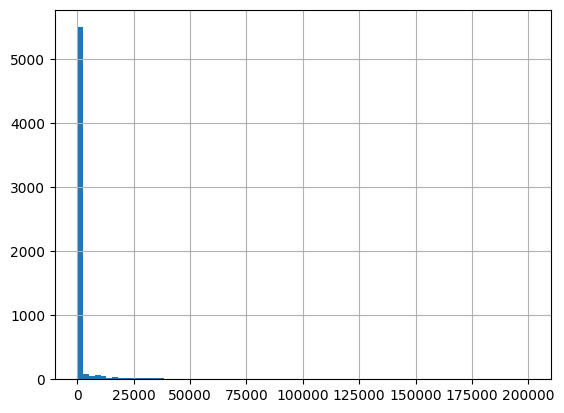

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
1006,7.05,mg/L,NaN,7.05 milligram / liter
1141,7.57,mg/L,NaN,7.57 milligram / liter
1174,3.5,mg/L,NaN,3.5 milligram / liter
3041,3.8,mg/L,NaN,3.8 milligram / liter
3921,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
456814,7.01,mg/l,NaN,7.01 milligram / liter
456883,5.96,mg/l,NaN,5.96 milligram / liter
456926,4.1,mg/l,NaN,4.1 milligram / liter
456932,7.79,mg/l,NaN,7.79 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/harmonize.py:149: UserWarning: Bad Turbidity unit: count
  warn(f"Bad Turbidity unit: {unit}")


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    29171.000000
mean        18.052962
std         78.056340
min       -999.000000
25%          1.400000
50%          2.890000
75%          6.500000
max       4100.000000
dtype: float64
Unusable results: 547
Usable results with inferred units: 275
Results outside threshold (0.0 to 486.3910018894372): 190


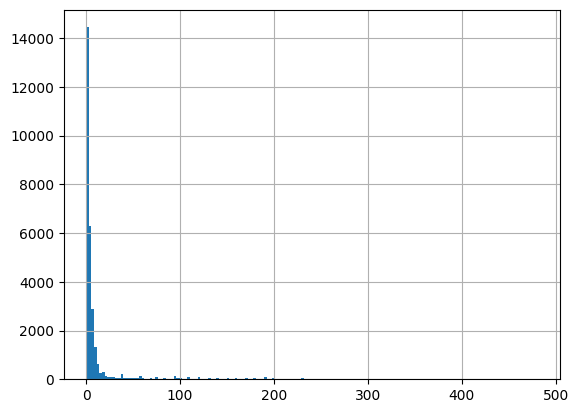

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
1,1,NTU,NaN,1.0 Nephelometric_Turbidity_Units
3,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
7,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
11,5.2,NTU,NaN,5.2 Nephelometric_Turbidity_Units
14,7.9,NTU,NaN,7.9 Nephelometric_Turbidity_Units
...,...,...,...,...
456987,1.6,NTRU,NaN,1.6 Nephelometric_Turbidity_Units
456997,5.8,NTRU,NaN,5.8 Nephelometric_Turbidity_Units
457001,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
457005,2.9,NTRU,NaN,2.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False, errors='ignore')

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
415606,0.012,g,NaN,NaN
415607,0.0037,g,NaN,NaN
415608,0.0048,g,NaN,NaN
415609,0.001,g,NaN,NaN
415610,0.0088,g,NaN,NaN
...,...,...,...,...
456076,0.0051,g,NaN,NaN
456150,0.0025,g,NaN,NaN
456222,0.002,g,NaN,NaN
456261,0.0023,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
33,0.024,mg/L,NaN,NaN
36,0.05,mg/L,NaN,NaN
46,0.027,mg/L,NaN,NaN
57,0.059712,mg/L,NaN,NaN
111,0.049,mg/L,NaN,NaN
...,...,...,...,...
456283,0.006,mg/l as P,NaN,0.006 milligram / liter
456295,0.016,mg/l as P,NaN,NaN
456296,0.008,mg/l as P,NaN,0.008 milligram / liter
456303,0.047,mg/l as P,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
33,0.024,mg/L,NaN,NaN
36,0.05,mg/L,NaN,NaN
46,0.027,mg/L,NaN,NaN
57,0.059712,mg/L,NaN,NaN
111,0.049,mg/L,NaN,NaN
...,...,...,...,...
456257,0.036,mg/l as P,NaN,NaN
456268,0.021,mg/l as P,NaN,NaN
456282,0.011,mg/l as P,NaN,NaN
456295,0.016,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
46458,0.023,ppm,NaN,0.023000000000000003 milligram / liter
50488,0.035,ppm,NaN,0.03500000000000001 milligram / liter
52411,0.017,ppm,NaN,0.017000000000000005 milligram / liter
52575,0.015,ppm,NaN,0.015000000000000003 milligram / liter
53985,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
456258,0.015,mg/l as P,NaN,0.015 milligram / liter
456269,0.005,mg/l as P,NaN,0.005 milligram / liter
456283,0.006,mg/l as P,NaN,0.006 milligram / liter
456296,0.008,mg/l as P,NaN,0.008 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
35360,0.03525375,mg/L,NaN,NaN
35468,0.107028125,mg/L,NaN,NaN
36001,0.0697675,mg/L,NaN,NaN
36219,0.04356,mg/L,NaN,NaN
36367,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
446365,530.0,mg/kg,NaN,NaN
447702,280.0,mg/kg,NaN,NaN
448476,270.0,mg/kg,NaN,NaN
448722,260.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5762
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.70806108734): 7


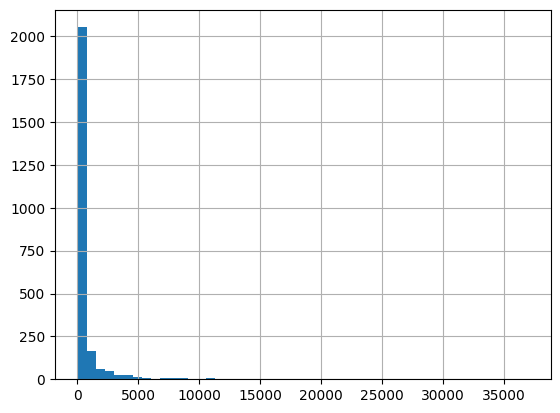

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
9819,40,#/100mL,NaN,NaN
9891,9,#/100mL,NaN,NaN
9900,20,#/100mL,NaN,NaN
10080,200,#/100mL,NaN,NaN
10274,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
452846,2400.0,cfu/100mL,NaN,NaN
452848,230.0,cfu/100mL,NaN,NaN
452852,30.0,cfu/100mL,NaN,NaN
452856,NaN,cfu/100mL,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'CFUcol/100mL' UNDEFINED UNIT for E_coli
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     5189.000000
mean       245.882382
std       1752.315000
min          0.000000
25%          0.500000
50%         30.000000
75%        128.000000
max      72000.000000
dtype: float64
Unusable results: 22187
Usable results with inferred units: 0
Results outside threshold (0.0 to 10759.772381268724): 14


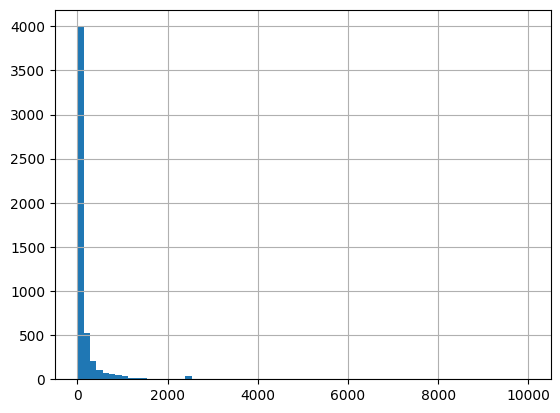

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
6,96,MPN/100mL,NaN,NaN
17,24200,MPN/100mL,NaN,NaN
20,110,MPN/100mL,NaN,NaN
24,52,MPN/100mL,NaN,NaN
30,52,MPN/100mL,NaN,NaN
...,...,...,...,...
456983,7.0,MPN/100 ml,NaN,7.0 Colony_Forming_Units / milliliter
456996,870.0,MPN/100 ml,NaN,870.0 Colony_Forming_Units / milliliter
457000,44.0,MPN/100 ml,NaN,44.0 Colony_Forming_Units / milliliter
457004,14.0,MPN/100 ml,NaN,14.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 36885 
Mean: 20.630282428521276 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
28241,804,ppth,NaN,804.0 Practical_Salinity_Units
170499,71.49,ppth,NaN,71.49 Practical_Salinity_Units
171508,70.62,ppth,NaN,70.62 Practical_Salinity_Units
213281,77.666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
423775,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [78]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
13244,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
13788,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
14011,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
20978,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
22529,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
357908,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
358002,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
358055,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
358060,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [79]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

22              349.0 microsiemens / centimeter
23            49700.0 microsiemens / centimeter
44              443.0 microsiemens / centimeter
52        67.11703531 microsiemens / centimeter
73            40500.0 microsiemens / centimeter
                          ...                  
404648        20579.0 microsiemens / centimeter
404698        38432.0 microsiemens / centimeter
404705        37791.0 microsiemens / centimeter
404715        40652.0 microsiemens / centimeter
404718        19003.0 microsiemens / centimeter
Name: Conductivity, Length: 8662, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [80]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
219037,57700.0,uS/cm,NaN,NaN,57700.0 microsiemens / centimeter
270661,52.418,mS/cm,NaN,NaN,52418.0 microsiemens / centimeter
281035,51.618,mS/cm,NaN,NaN,51618.0 microsiemens / centimeter
268485,51.325,mS/cm,NaN,NaN,51325.0 microsiemens / centimeter
50992,51.05,mS/cm,NaN,NaN,51050.0 microsiemens / centimeter
...,...,...,...,...,...
6320,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
79212,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter
79161,0,mS/cm,NaN,NaN,0.0 microsiemens / centimeter
3762,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [81]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

219037    38.468 dimensionless
270661    34.521 dimensionless
281035    33.929 dimensionless
268485    33.713 dimensionless
50992      33.51 dimensionless
                  ...         
6320       0.012 dimensionless
79212      0.012 dimensionless
79161      0.012 dimensionless
3762       0.012 dimensionless
8042       0.012 dimensionless
Name: Salinity, Length: 8662, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
219037,2021-06-21,NaN,NaN
270661,2022-08-09,12:58:00,EST
281035,2022-08-09,13:25:00,EST
268485,2022-07-25,11:40:00,EST
50992,2016-08-15,NaN,NaN
...,...,...,...
457005,2024-01-08,12:00:00,EST
457006,2024-02-12,08:45:00,EST
457007,2024-02-12,08:45:00,EST
457008,2024-02-12,08:45:00,EST


In [83]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 167291 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
219037,2021-06-21,NaT
270661,2022-08-09,2022-08-09 17:58:00+00:00
281035,2022-08-09,2022-08-09 18:25:00+00:00
268485,2022-07-25,2022-07-25 16:40:00+00:00
50992,2016-08-15,NaT
...,...,...
457005,2024-01-08,2024-01-08 17:00:00+00:00
457006,2024-02-12,2024-02-12 13:45:00+00:00
457007,2024-02-12,2024-02-12 13:45:00+00:00
457008,2024-02-12,2024-02-12 13:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [84]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

126083    0.15
127608    0.15
85180     0.15
89973     0.15
126595    0.15
          ... 
320467    0.15
320516    0.15
320523    0.15
320551    0.15
320587    0.15
Name: ResultDepthHeightMeasure/MeasureValue, Length: 2460, dtype: float64

#### Characteristic to Column (long to wide format)

In [85]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Other_Phosphorus,QA_pH,QA_E_coli,QA_Carbon,QA_Temperature,QA_Salinity,QA_Secchi,QA_Sediment,QA_Fecal_Coliform,QA_Chlorophyll
219037,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,2021-06-21,NaN,NaN,NARS_WQX-NWC_RI-10033,STORET-1040684142,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270661,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,2022-08-09,12:58:00,-0500,WTGHA-P3,STORET-1041330082,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281035,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,2022-08-09,13:25:00,-0500,WTGHA-P4,STORET-1041330098,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268485,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220725114000:FM:B,2022-07-25,11:40:00,-0500,WTGHA-P3,STORET-1041329903,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50992,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20160815:FM:B,2016-08-15,NaN,NaN,WTGHA-P3,STORET-1041309861,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457005,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,-0500,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457006,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457007,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457008,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [87]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

38068 fewer rows


In [88]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [89]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [90]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Nitrogen', 'QA_Turbidity',
       'QA_Conductivity', 'QA_DO', 'QA_TP_Phosphorus', 'QA_TDP_Phosphorus',
       'QA_Other_Phosphorus', 'QA_pH', 'QA_E_coli', 'QA_Carbon',
       'QA_Temperature', 'QA_Salinity', 'QA_Secchi', 'QA_Sediment',
       'QA_Fecal_Coliform', 'QA_Chlorophyll'],
      dtype='object')

In [91]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Other_Phosphorus,QA_pH,QA_E_coli,QA_Carbon,QA_Temperature,QA_Salinity,QA_Secchi,QA_Sediment,QA_Fecal_Coliform,QA_Chlorophyll
219037,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-185450_2021,NARS_WQX-NWC_RI-10033,STORET,NaN,NaN,NaN,NaN,38.468 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270661,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220809125800:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,34.521 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281035,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P4:20220809132500:FM:B,WTGHA-P4,STORET,NaN,NaN,NaN,NaN,33.929 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268485,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20220725114000:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,33.713 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50992,WTGHA,Wompanoag Tribe of Gay Head Aquinnah (Tribal),WTGHA-P3:20160815:FM:B,WTGHA-P3,STORET,NaN,NaN,NaN,NaN,33.51 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'DetectionQuantitationLimitTypeName',
 'DetectionQuantitationLimitMeasure/MeasureValue',
 'DetectionQuantitationLimitMeasure/MeasureUnitCode',
 'QA_Conductivity',
 'QA_DO',
 'QA_TDP_Phosphorus',
 'QA_Carbon',
 'QA_Sediment']

<Axes: >

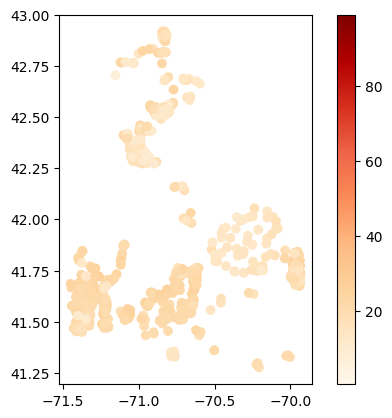

In [93]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)